### DESEQ2 analysis of Hydrogel dataset

2 Factor design: 

* Stiffness (Soft v Stiff) 
* Saha (yes, no) 

* 221511 naive overlap peaks 
* 3 biological replicates per Sample 

In [63]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

## Load data and design

In [64]:
#load ATAC-seq raw read counts
data=read.table('hydrogel.soft.stiff.saha.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL

data=data[rowSums(data)>0,]


In [65]:
head(data)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3,saha_2000Pa_Rep1,saha_2000Pa_Rep2,saha_2000Pa_Rep3
chr1_713708_714452,6,11,7,17,27,17,25,23,16,22,24,20
chr1_762643_763047,1,5,0,3,7,4,5,5,2,3,6,7
chr1_802987_803295,2,7,4,3,3,1,8,6,6,7,8,4
chr1_804984_805589,2,6,1,6,7,6,7,3,4,5,16,4
chr1_834765_835239,7,12,14,15,7,9,5,2,0,8,10,4
chr1_839144_839717,13,17,5,23,15,20,6,4,3,5,12,11


In [66]:
#load the metadata
batches=read.table("batches_hydrogel.soft.stiff.saha.txt",header=TRUE,sep='\t',row.names=1)
batches$Stiffness=factor(batches$Stiffness)
batches$Saha=factor(batches$Saha)
batches$Sample=factor(batches$Sample)


In [67]:
batches

,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa
saha_100Pa_Rep1,Soft,Yes,saha_100Pa
saha_100Pa_Rep2,Soft,Yes,saha_100Pa
saha_100Pa_Rep3,Soft,Yes,saha_100Pa
saha_2000Pa_Rep1,Stiff,Yes,saha_2000Pa


## Soft vs Stiff Analysis 


In [68]:
soft_stiff_data=data[,1:6]
soft_stiff_batches=batches[1:6,]

In [69]:
head(soft_stiff_data)
soft_stiff_batches

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr1_713708_714452,6,11,7,17,27,17
chr1_762643_763047,1,5,0,3,7,4
chr1_802987_803295,2,7,4,3,3,1
chr1_804984_805589,2,6,1,6,7,6
chr1_834765_835239,7,12,14,15,7,9
chr1_839144_839717,13,17,5,23,15,20


,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa


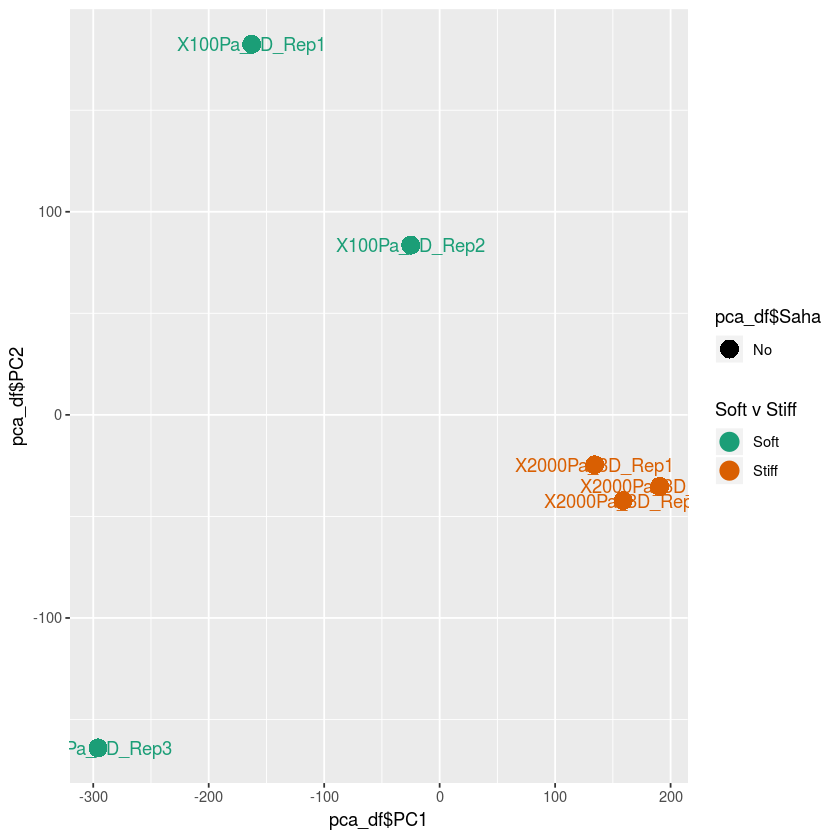

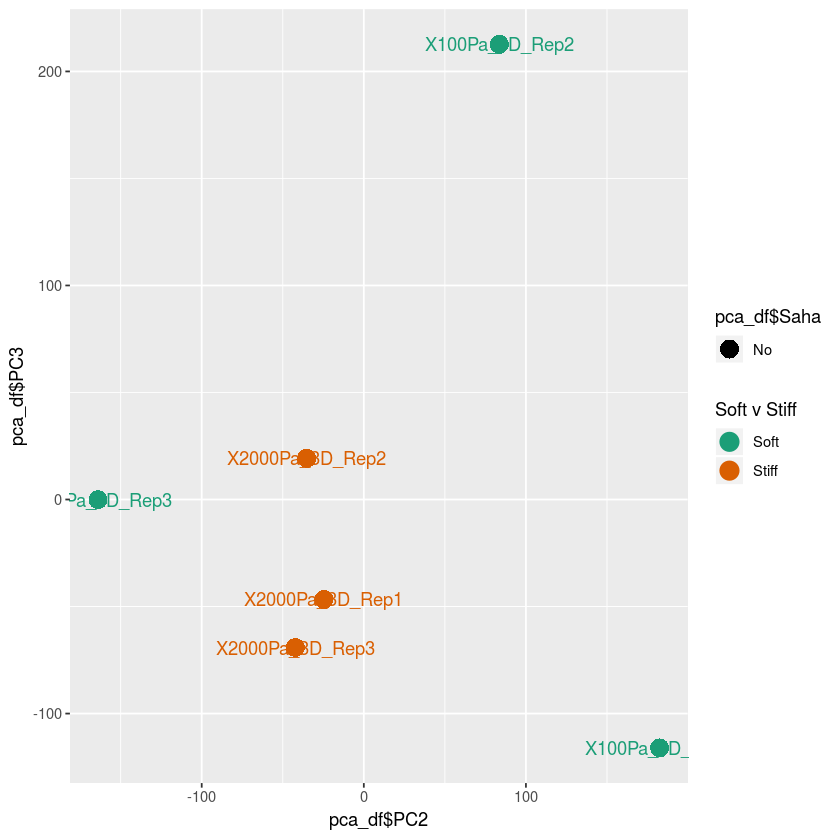

In [70]:
#PCA on shifted log of normalized counts
normcounts=soft_stiff_data
normcounts[normcounts<0]=0
lognc=log2(normcounts+1)
data.pca=prcomp(t(lognc))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)

pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

In [71]:
#Surrogate Variable Analysis 
soft_stiff_data=soft_stiff_data[rowSums(soft_stiff_data)>0,]
mod0=model.matrix(~1,data=soft_stiff_batches)
mod1=model.matrix(~Stiffness,data=soft_stiff_batches)
sva.obj=svaseq(as.matrix(soft_stiff_data),mod1,mod0)


Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [72]:
sur_var=data.frame(sva.obj$sv)
names(sur_var)=c("sv1","sv2")
soft_stiff_batches=cbind(soft_stiff_batches,sur_var)

In [73]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = soft_stiff_data,
                              colData = soft_stiff_batches,
                              design = ~Stiffness+sv1+sv2)


In [74]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("background/hydrogel.soft.stiff.saha.HK.txt",header=FALSE,sep='\t')
hk_promoters=paste(hk_promoters[,1],hk_promoters[,2],hk_promoters[,3],sep="_")
soft_stiff_hk_promoter_indices=match(hk_promoters,rownames(soft_stiff_data))
head(soft_stiff_hk_promoter_indices)

[1] 15 63 70 71 71 78

In [75]:
dds <- estimateSizeFactors(dds, controlGenes=soft_stiff_hk_promoter_indices)

## Extract and store normalized counts for further analysis 

In [76]:
normcounts=counts(dds,normalized=TRUE)

#use limma's removeBatchEffect function 
tokeep=model.matrix(~Stiffness,data=soft_stiff_batches)
normcounts=removeBatchEffect(normcounts,design=tokeep,covariates = subset(soft_stiff_batches,select=c("sv1","sv2")))


write.table(normcounts,"soft_stiff_normcounts_from_deseq.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)


In [77]:
head(normcounts)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr1_713708_714452,10.389286,8.994839,10.072496,14.223168,18.900482,13.768883
chr1_762643_763047,2.166286,1.837060,2.091492,2.829489,4.345750,3.546150
chr1_802987_803295,5.151955,5.205100,5.164028,2.702348,1.678516,1.028523
chr1_804984_805589,3.249119,3.428959,3.289975,5.216856,4.504169,5.056520
chr1_834765_835239,13.724373,14.860052,13.982376,12.058272,5.473034,6.876461
chr1_839144_839717,13.166284,15.031777,13.590085,18.932519,10.868778,15.927412


## Differential Accessibility Operation

In [78]:
#Run the differential analysis
dds <- DESeq(dds,parallel = TRUE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates, fitting model and testing: 20 workers


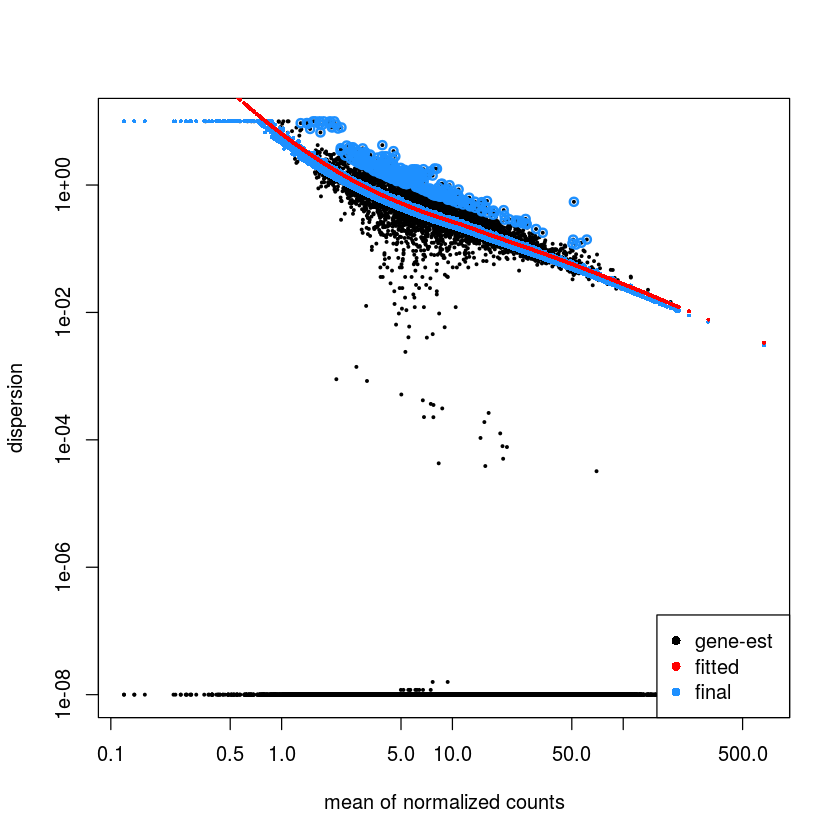

In [79]:
plotDispEsts(dds)

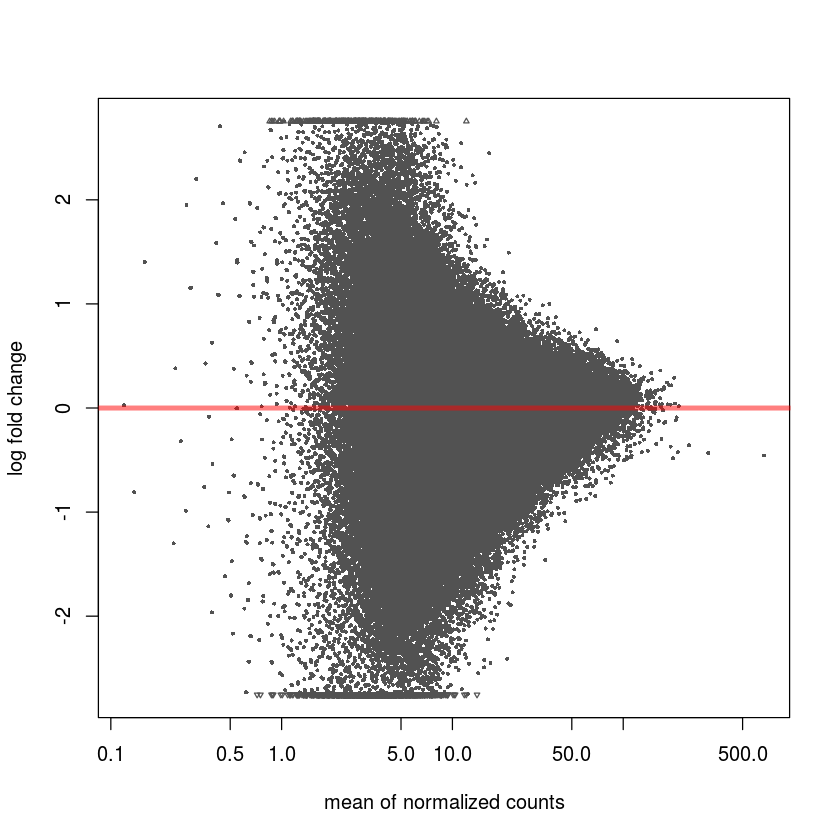

In [80]:
DESeq2::plotMA(dds)

## Standard BH Correction (no optimal thresholding) 

In [81]:
res=results(dds)
summary(res)

res=results(dds,independentFiltering=FALSE)
summary(res)

res=results(dds,filterFun = ihw)
summary(res)


out of 221485 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221485 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221485 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [82]:

resultsNames(dds)

[1] "Intercept"               "Stiffness_Stiff_vs_Soft"
[3] "sv1"                     "sv2"

In [83]:
res=results(dds,name="Stiffness_Stiff_vs_Soft",parallel=TRUE)

[1] 12


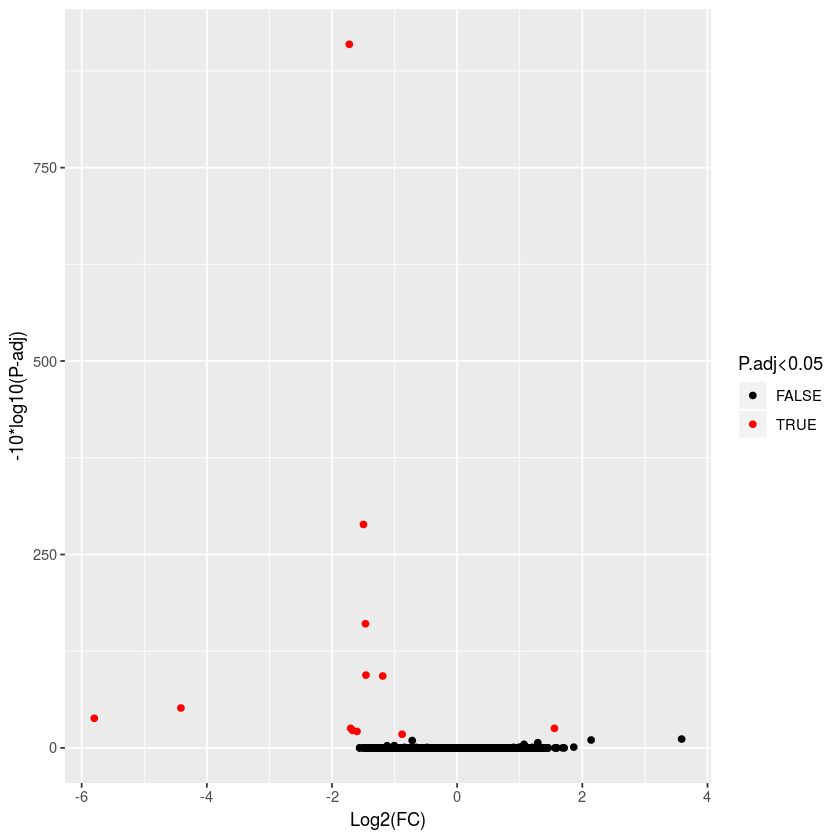

In [84]:
        res$logPadj=-10*log10(res$padj)
        res=as.data.frame(res)
        res=na.omit(res)
        numsig=sum(res$padj <= 0.05)
        sigsubset=res[res$padj<=0.05,]
        res$color=res$padj<=0.05
        ggplot(data=res,
        aes(x=res$log2FoldChange,
                 y=res$logPadj,
                 color=res$color))+
                 geom_point()+
                 xlab("Log2(FC)")+
                 ylab("-10*log10(P-adj)")+
                 scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05")
print(numsig)

## Visualizations 

In [85]:
#PCA on shifted log of normalized counts
normcounts[normcounts<0]=0 
lognorm=log2(normcounts+1)
data.pca=prcomp(t(lognorm))
#rld=assay(rlog(dds,blind=FALSE))
#data.pca=prcomp(t(rld))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)



In [107]:
var_explained_df

seq.1..length.var_explained..,var_explained
1,50.16
2,26.12
3,23.53
4,0.18
5,0.00
6,0.00


In [86]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


png 
  2

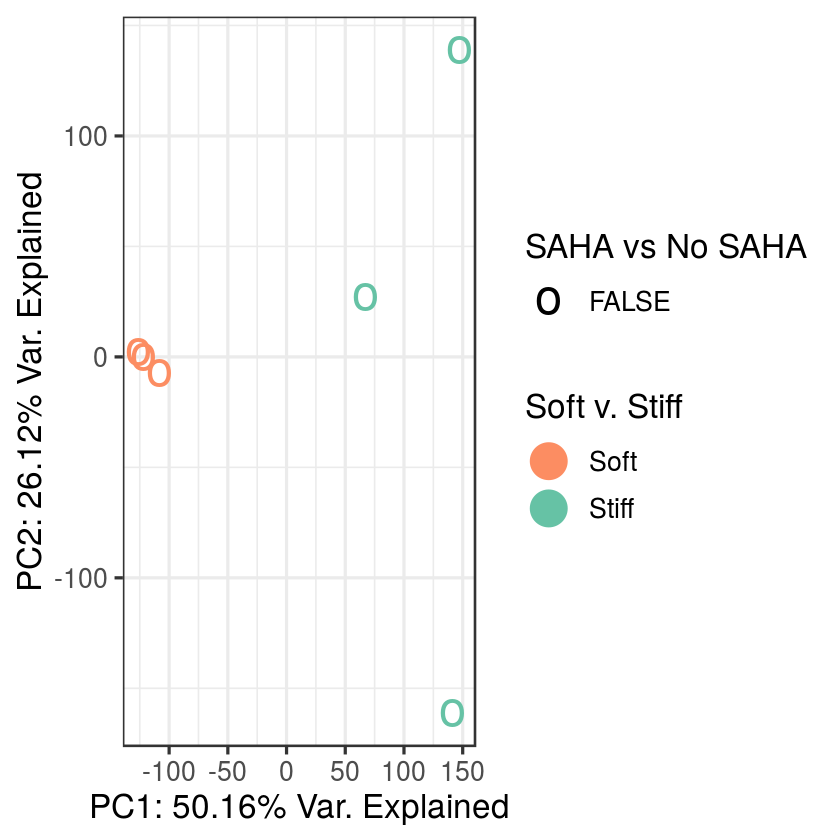

In [108]:
pca_df$Saha=c(FALSE,FALSE,FALSE,FALSE,FALSE,FALSE)
pca_df$Stiffness=c("Soft","Soft","Soft","Stiff","Stiff","Stiff")
pca_df$Saha=factor(pca_df$Saha)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Stiffness,shape=pca_df$Saha))+
  geom_point(size=10) +
  xlab("PC1: 50.16% Var. Explained")+
  ylab("PC2: 26.12% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c("#fc8d62","#66c2a5"),name="Soft v. Stiff")+
  scale_shape_manual(values=c("o","x"),name="SAHA vs No SAHA")
p1
svg("pca.no.saha.svg",width = 8, height = 4, pointsize = 12)
print(p1)
dev.off()

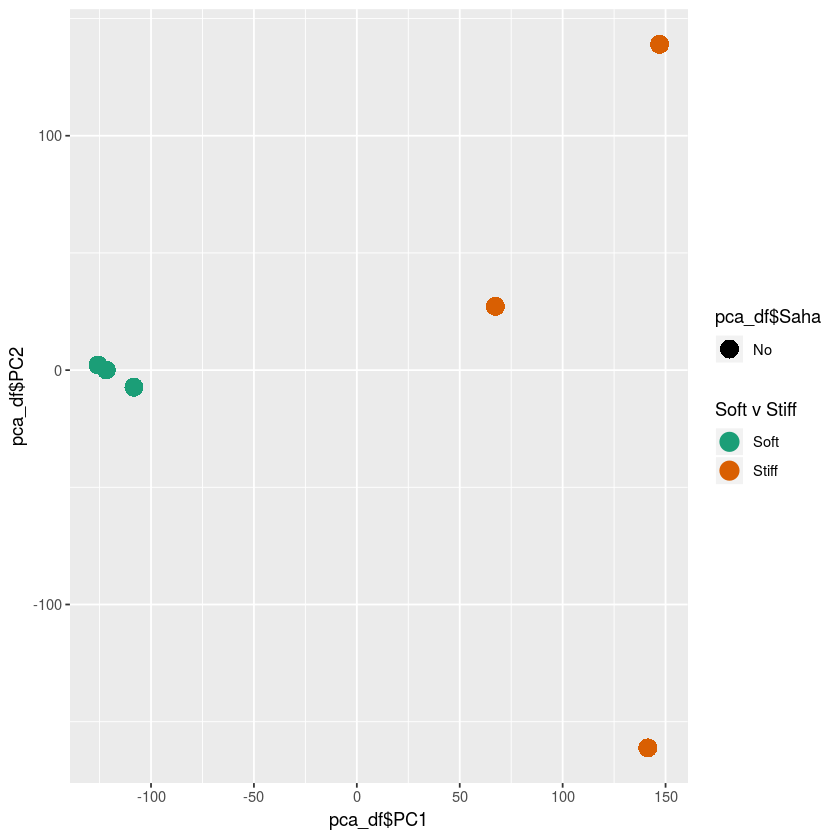

In [87]:
p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

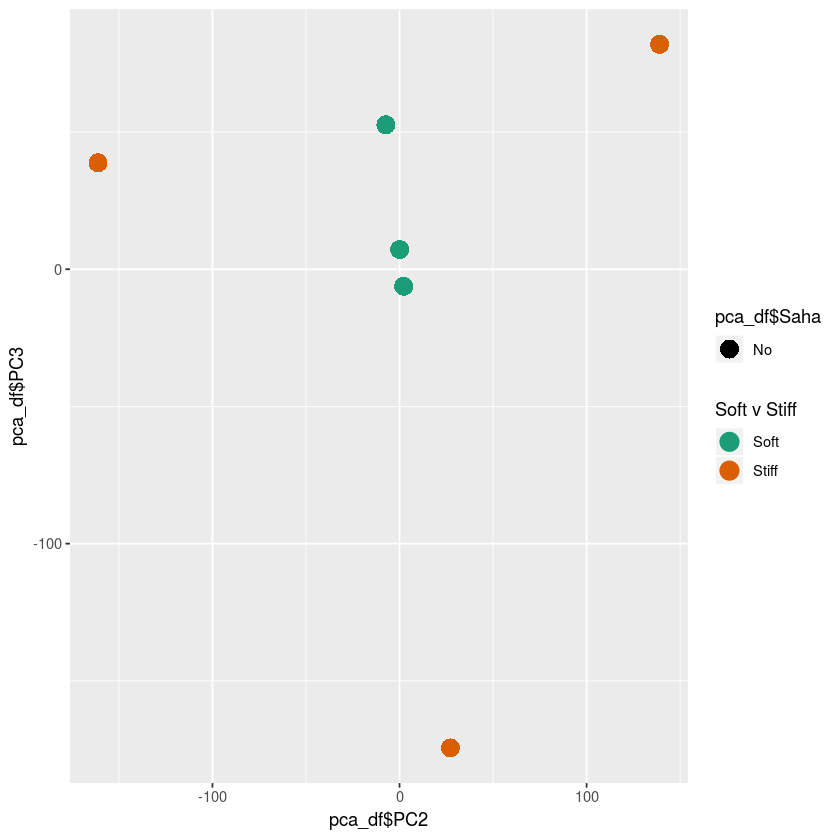

In [92]:
p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

## Get contributions to PC1 

In [93]:
pc1_loadings=sort(data.pca$rotation[, 1])

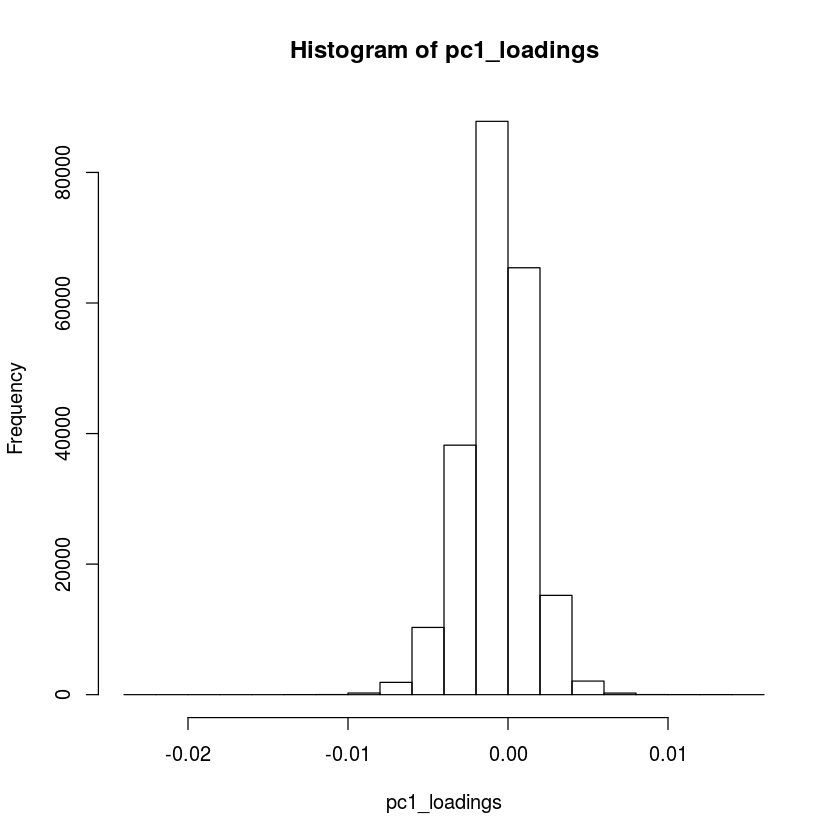

In [94]:
hist(pc1_loadings)

In [95]:
lower_bound=mean(pc1_loadings)-3*sd(pc1_loadings)
upper_bound=mean(pc1_loadings)+3*sd(pc1_loadings)

In [96]:
toselect=c(names(pc1_loadings[pc1_loadings<lower_bound]),names(pc1_loadings[pc1_loadings>upper_bound]))

In [98]:
#heatmap_indices=match(toselect,rownames(rld))
heatmap_indices=match(toselect,rownames(lognorm))
head(heatmap_indices)
forheatmap=lognorm[heatmap_indices,]

[1]  13194 135361  98289 153607 155151  60424

In [99]:
head(forheatmap)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr1_169443229_169443466,6.687804,6.656407,6.680731,0.0000000,2.982403,0.7579551
chr3_68708135_68708352,5.318151,5.322642,5.319172,2.2196930,1.356143,0.4190160
chr19_50594292_50594473,3.430532,3.368245,3.416615,0.0000000,1.046558,0.0000000
chr4_167789411_167789675,3.239682,3.253468,3.242825,0.1537797,0.000000,0.1537797
chr4_190942911_190943138,3.200181,3.121682,3.182719,0.0000000,1.096086,0.0000000
chr13_107440288_107440622,3.598780,3.467876,3.570067,0.0000000,2.229831,0.4781962


In [103]:
nrow(forheatmap)

[1] 1588

In [100]:
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(100)

In [101]:
df <- as.data.frame(colData(dds)[,'Stiffness'])


png 
  2

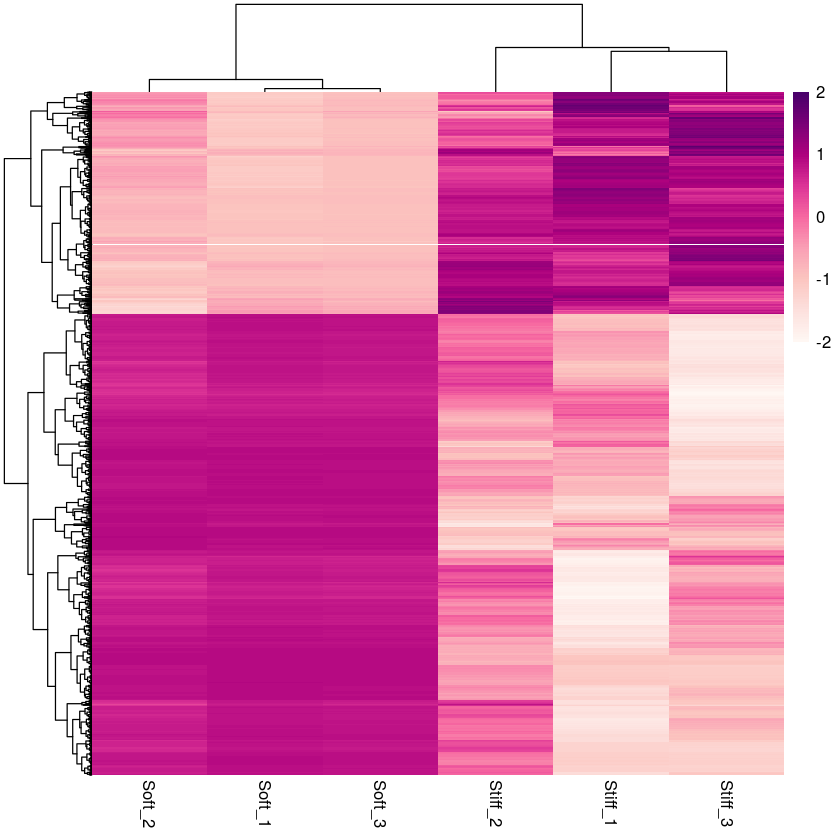

In [109]:
p1=pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='row',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3"))
svg("soft.stiff.zscores.svg")
print(p1)
dev.off() 


In [104]:
head(rownames(forheatmap))

[1] "chr1_169443229_169443466"  "chr3_68708135_68708352"   
[3] "chr19_50594292_50594473"   "chr4_167789411_167789675" 
[5] "chr4_190942911_190943138"  "chr13_107440288_107440622"

In [105]:
write.table(forheatmap,file="pc1.soft.stiff.highest.tsv",row.names=TRUE,col.names=TRUE,sep='\t')